## load packages

In [2]:
library(dplyr)
library(lubridate)
library(tableone)
library(DescTools)
library(biostat3)
library(survminer)
library(mice)
library(foreach)
library(mgcv)
library(doParallel)
library(mitools)
library(survey)
library(ipw)
library(rms)
library(tidyr)
library(EValue)
library(rpart)
library(data.table)
library(snow)
library(forestplot)
library(parglm)

In [3]:
## HR display function
OR.result.tidy <- function(result) {
    res <- result$coefficients[2, c(1, 2)]
    OR <- exp(res[1])
    lci <- exp(res[1] - qnorm(0.975) * res[2])
    uci <- exp(res[1] + qnorm(0.975) * res[2])
    res <- data.frame(OR, lci, uci)
    colnames(res) <- c('OR', 'lci', 'uci')
    res <- res %>% 
        data.frame() %>% 
        mutate_at(vars(OR, lci, uci), funs(round(., 2))) 
    res <- res %>% 
        mutate(OR = paste0(res[, 1], " (", res[, 2], "-", res[, 3], ")")) %>% 
        cbind(group = c('discontinuation')) %>% 
        dplyr::select(c(4, 1))
    res <- rbind(data.frame(group = 'reinitiation', OR = 'Ref'), res) 
    res$group <- as.character(res$group)
    return(res)
}

## import data

In [4]:
load('dta_tidied.R')

In [5]:
dta_clone_cataract <- dta_clone %>% filter(cov_cataract == 0)

In [6]:
length(unique(dta_clone$lopnr)) - length(unique(dta_clone_cataract$lopnr))

[1] 724

In [7]:
dta_clone_cataract <- dta_clone %>% 
    arrange(X, lopnr, index_date) %>% 
    group_by(X, lopnr) %>% 
    mutate(death_filter = cumsum(outcome_death), 
           censor_filter = cumsum(censor), 
           cataract_filter = cumsum(outcome_cataract)) %>% 
    filter(death_filter <= 1 & censor_filter <= 1 & cataract_filter <= 1) %>% 
    ungroup() %>% 
    dplyr::select(c('lopnr', 'ID', 'X', 
                    'index_date', 'after_index_date', 'rank', 
                    'age', 'female', 'index_year', 'duration', 
                    'cov_diabetes_t0', 'cov_hypertension_t0', 
                    'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                    'cov_cancer_t0', 'cov_COPD_t0', 
                    'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                    'cov_statin_t0', 
                    'cov_antiplatelet_agent_t0', 
                    'cov_egfr_t0', 'cov_egfr_cat_t0', 'cov_acr_t0', 'cov_acr_cat_t0', 
                    'potassium_value', 'potassium_cat', 
                    'cov_hospitalization_t0', 
                    'primary_care_num', 'outpatient_num', 'inpatient_num', 
                    'cov_diabetes', 'cov_hypertension', 
                    'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                    'cov_cancer', 'cov_COPD',  
                    'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                    'cov_statin', 
                    'cov_antiplatelet_agent', 
                    'cov_egfr', 'cov_egfr_cat', 'cov_acr', 'cov_acr_cat', 
                    'cov_potassium', 'cov_hospitalization', 
                    'outcome_cataract', 'censor', 'treatment'))

## description of chracteristics at month 6 (unweighted)

In [8]:
dta_clone_cataract_6_month <- dta_clone_cataract %>% filter(rank == 6)

In [9]:
xvars <- c('age', 'female', 'index_year', 'duration', 'potassium_cat', 
           'cov_diabetes', 'cov_hypertension', 
           'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
           'cov_cancer', 'cov_COPD',  
           'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
           'cov_statin', 
           'cov_antiplatelet_agent', 
           # 'cov_potassium', 
           'cov_egfr_cat', 
           'primary_care_num', 'cov_hospitalization', 'outpatient_num', 'inpatient_num')
xfactorvars <- c('female', 'index_year', 'potassium_cat', 
                 'cov_diabetes', 'cov_hypertension', 
                 'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                 'cov_cancer', 'cov_COPD',  
                 'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                 'cov_statin', 
                 'cov_antiplatelet_agent', 
                 'cov_egfr_cat', 'cov_hospitalization')
xnonnormvars <- c('duration', # 'cov_potassium', 
                  'primary_care_num', 'outpatient_num', 'inpatient_num')

In [10]:
tb1.part <- CreateTableOne(xvars, strata = 'X', data = dta_clone_cataract_6_month, factorVars = xfactorvars, includeNA = T)
tb1.part <- print(tb1.part, nonnormal = xnonnormvars, test = F, smd = T, printToggle = F)

In [11]:
dta_clone_cataract_imp1 <- dta_clone_cataract

## description of cataract event in each arm (unweighted)

In [13]:
source('results function.R')
dta_clone_cataract_imp1_fixed <- dta_clone_cataract_imp1 %>% 
        arrange(ID, index_date) %>% 
        group_by(ID) %>% 
        summarise(index_date = min(index_date), 
                  after_index_date = max(after_index_date), 
                  outcome_cataract = sum(outcome_cataract), 
                  X = first(X))
incid_num('outcome_cataract', 'index_date', 'after_index_date', 'X', 
          dta_clone_cataract_imp1_fixed, digit = 2)

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


group,n,followup,event,person_years,incidence rate
discontinuation,5669,0.16 [0.08-0.33],115,2458.68,0.05 (0.04-0.06)
reinitiation,5669,1.16 [0.5-2.5],337,8799.56,0.04 (0.03-0.04)


## IPW calculation

In [14]:
x_adjusted_var <- c('age', 'female', 'index_year', 'rcs(duration, 3)', 'rcs(potassium_value, 3)', 
                    # 'cov_diabetes_t0', 'cov_hypertension_t0', 
                    # 'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                    # 'cov_COPD_t0', 
                    # 'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                    # 'cov_statin_t0', 
                    # 'cov_antiplatelet_agent_t0', 
                    # 'cov_egfr_t0', 
                    'primary_care_num', 
                    'outpatient_num', 
                    'inpatient_num', # 'cov_hospitalization_t0', 
                    'cov_diabetes', 'cov_hypertension', 
                    'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                    'cov_cancer', 'cov_COPD',  
                    'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                    'cov_statin', 
                    'cov_antiplatelet_agent', 
                    'rcs(cov_egfr, 6)', 
                    # 'rcs(cov_potassium, 12)', 
                    'cov_hospitalization')

In [15]:
x_adjusted_var_ML <- c('age', 'female', 'index_year', 'duration', 'potassium_value', 
                       # 'cov_diabetes_t0', 'cov_hypertension_t0', 
                       # 'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                       # 'cov_COPD_t0', 
                       # 'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                       # 'cov_statin_t0', 
                       # 'cov_antiplatelet_agent_t0', 
                       # 'cov_egfr_t0', 
                       'primary_care_num', 
                       'outpatient_num', 
                       'inpatient_num', # 'cov_hospitalization_t0', 
                       'cov_diabetes', 'cov_hypertension', 
                       'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                       'cov_cancer', 'cov_COPD',  
                       'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                       'cov_statin', 
                       'cov_antiplatelet_agent', 
                       'cov_egfr', 
                       # 'cov_potassium',
                       'cov_hospitalization')

In [16]:
dta_clone_cataract_imp1_discontinuation <- dta_clone_cataract_imp1 %>% 
    filter(X == 'discontinuation') %>% 
    arrange(ID, index_date)
dta_clone_cataract_imp1_discontinuation_censor_part <- dta_clone_cataract_imp1_discontinuation %>% 
    filter(rank %in% 1 : 6)
dta_clone_cataract_imp1_discontinuation_noncensor_part <- dta_clone_cataract_imp1_discontinuation %>% 
    filter(rank > 6)

In [17]:
## logistic regression formula
regression_formula_IPCW <- as.formula(paste0('censor ~ rank + rank ^ 2 + ', 
                                             paste(x_adjusted_var, collapse = " + "), 
                                             sep = ' '))
denominator.fit <- glm(regression_formula_IPCW, 
                       data = dta_clone_cataract_imp1_discontinuation_censor_part, 
                       family  = binomial(link = "logit"))
numerator.fit <- glm(censor ~ rank + rank ^ 2 + age + female + index_year + duration + potassium_value + 
                     primary_care_num + outpatient_num + inpatient_num + 
                     cov_diabetes_t0 + cov_hypertension_t0 + 
                     cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                     cov_cancer_t0 + cov_COPD_t0 + 
                     cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                     cov_MRA_t0 + cov_SPS_t0 + 
                     cov_statin_t0 + 
                     cov_antiplatelet_agent_t0 + 
                     cov_egfr_t0 + 
                     cov_hospitalization_t0, 
                     data = dta_clone_cataract_imp1_discontinuation_censor_part, 
                     family  = binomial(link = "logit"))
## machine learning formula
ML_formula_IPCW <- as.formula(paste0('censor ~ rank + ', 
                                     paste(x_adjusted_var_ML, collapse = " + "), 
                                     sep = ' '))
denominator.fit_ML <- rpart(ML_formula_IPCW, 
                         data = dta_clone_cataract_imp1_discontinuation_censor_part, 
                         method = 'class')
numerator.fit_ML <- rpart(censor ~ rank + age + female + index_year + duration + potassium_value + 
                          primary_care_num + outpatient_num + inpatient_num + 
                          cov_diabetes_t0 + cov_hypertension_t0 + 
                          cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                          cov_cancer_t0 + cov_COPD_t0 + 
                          cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                          cov_MRA_t0 + cov_SPS_t0 + 
                          cov_statin_t0 + 
                          cov_antiplatelet_agent_t0 + 
                          cov_egfr_t0 + 
                          cov_hospitalization_t0, 
                          data = dta_clone_cataract_imp1_discontinuation_censor_part, 
                          method = 'class')
## =============================================================================================================

In [18]:
## Stabilized IPW
dta_clone_cataract_imp1_discontinuation_censor_part$ipw_per_month <- 
    ifelse(dta_clone_cataract_imp1_discontinuation_censor_part$censor == 1, 
           0, 
           (1 - fitted(numerator.fit)) / (1 - fitted(denominator.fit)))
dta_clone_cataract_imp1_discontinuation_noncensor_part$ipw_per_month <- 1
## =============================================================================================================
## Unstabilized IPW
dta_clone_cataract_imp1_discontinuation_censor_part$ipw_uns_per_month <- 
    ifelse(dta_clone_cataract_imp1_discontinuation_censor_part$censor == 1, 
           0, 
           1 / (1 - fitted(denominator.fit)))
dta_clone_cataract_imp1_discontinuation_noncensor_part$ipw_uns_per_month <- 1
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_cataract_imp1_discontinuation_censor_part$ipw_ML_per_month <- 
    ifelse(dta_clone_cataract_imp1_discontinuation_censor_part$censor == 1, 
           0, 
           predict(numerator.fit_ML)[, 1] / predict(denominator.fit_ML)[, 1])
dta_clone_cataract_imp1_discontinuation_noncensor_part$ipw_ML_per_month <- 1
## =============================================================================================================

In [19]:
dta_clone_cataract_imp1_discontinuation <- rbind(dta_clone_cataract_imp1_discontinuation_censor_part, 
                                              dta_clone_cataract_imp1_discontinuation_noncensor_part) %>% 
    arrange(ID, index_date)
## Stabilized IPW
dta_clone_cataract_imp1_discontinuation$ipw <- unlist(tapply(dta_clone_cataract_imp1_discontinuation$ipw_per_month, 
                                                         dta_clone_cataract_imp1_discontinuation$ID, cumprod))
## =============================================================================================================
## Unstabilized IPW
dta_clone_cataract_imp1_discontinuation$ipw_uns <- unlist(tapply(dta_clone_cataract_imp1_discontinuation$ipw_uns_per_month, 
                                                              dta_clone_cataract_imp1_discontinuation$ID, cumprod))
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_cataract_imp1_discontinuation$ipw_ML <- unlist(tapply(dta_clone_cataract_imp1_discontinuation$ipw_ML_per_month, 
                                                             dta_clone_cataract_imp1_discontinuation$ID, cumprod))
## =============================================================================================================

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.8265  0.9727  0.8626  1.0656  2.1888 

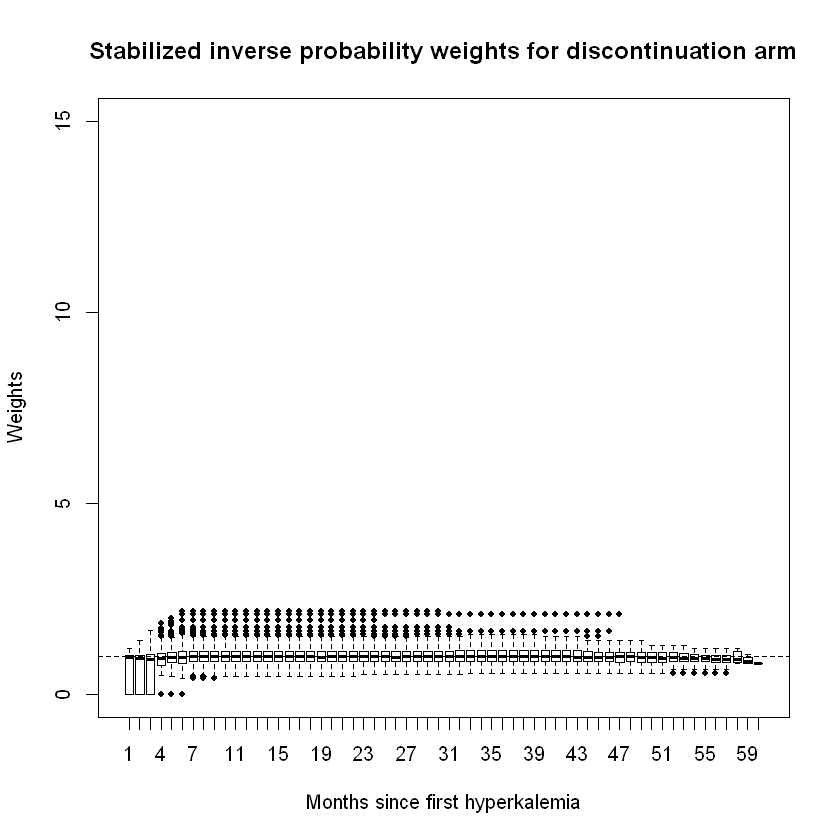

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.663   3.102   3.808   5.190  33.948 

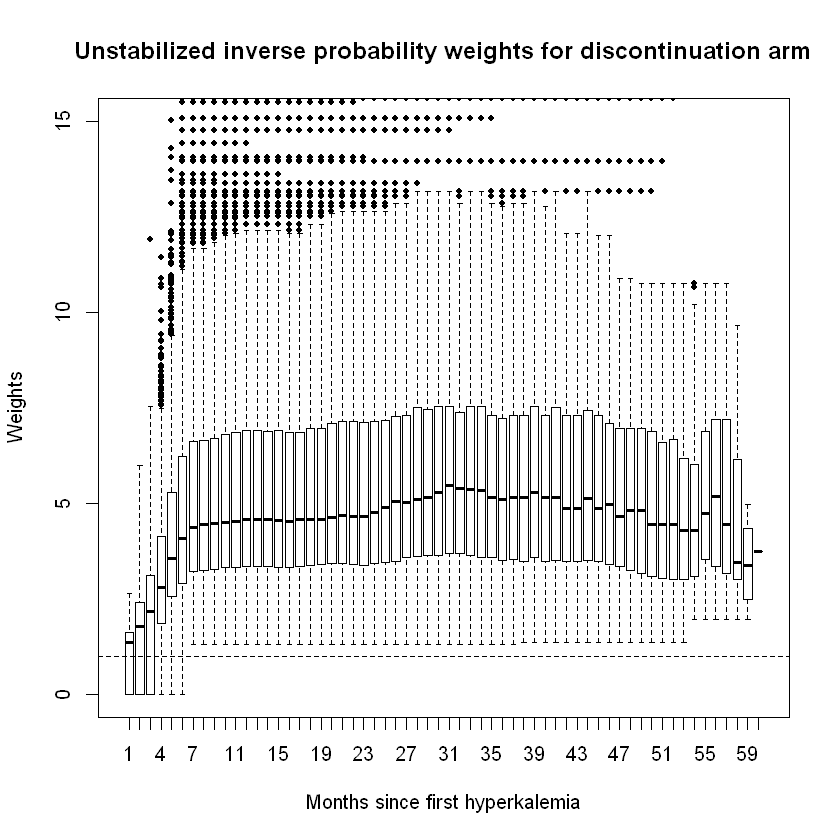

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.8576  1.0000  1.0000 

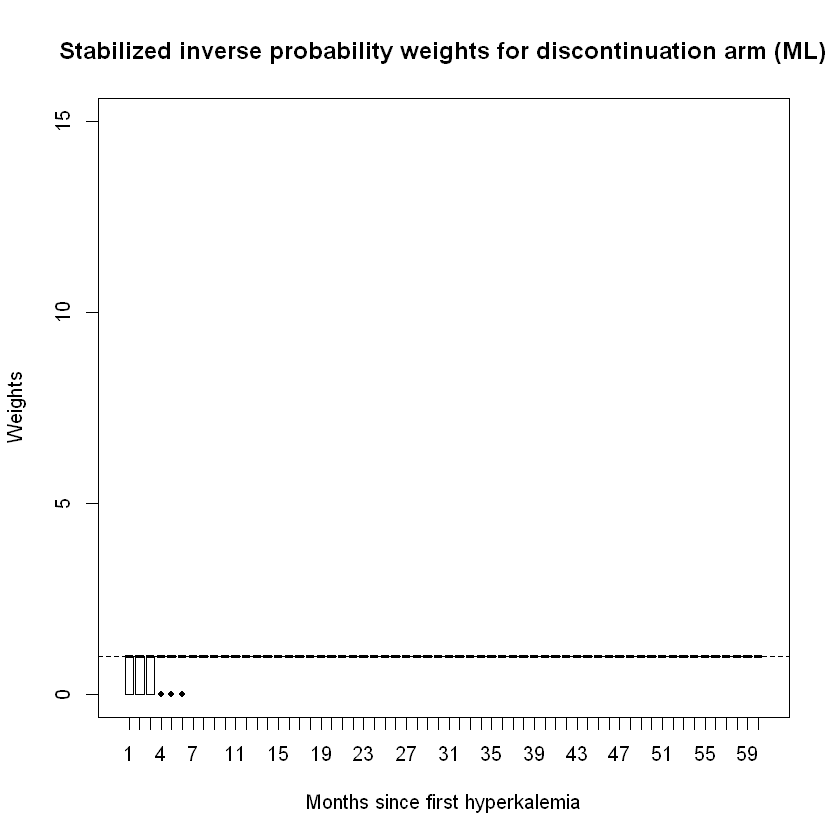

In [20]:
ipwplot(dta_clone_cataract_imp1_discontinuation$ipw, dta_clone_cataract_imp1_discontinuation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for discontinuation arm', 
        ylim = c(0, 15))
summary(dta_clone_cataract_imp1_discontinuation$ipw)
ipwplot(dta_clone_cataract_imp1_discontinuation$ipw_uns, dta_clone_cataract_imp1_discontinuation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Unstabilized inverse probability weights for discontinuation arm', 
        ylim = c(0, 15))
summary(dta_clone_cataract_imp1_discontinuation$ipw_uns)
ipwplot(dta_clone_cataract_imp1_discontinuation$ipw_ML, dta_clone_cataract_imp1_discontinuation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for discontinuation arm (ML)', 
        ylim = c(0, 15))
summary(dta_clone_cataract_imp1_discontinuation$ipw_ML)

In [21]:
dta_clone_cataract_imp1_reinitiation <- dta_clone_cataract_imp1 %>% 
    filter(X == 'reinitiation') %>% 
    arrange(ID, index_date)
dta_clone_cataract_imp1_reinitiation_censor_part <- dta_clone_cataract_imp1_reinitiation %>% 
    filter(rank == 6)
dta_clone_cataract_imp1_reinitiation_noncensor_part <- dta_clone_cataract_imp1_reinitiation %>% 
    filter(rank %in% 1 : 5 | rank > 6)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.9746  1.0000  0.9928  1.0157  2.1097 

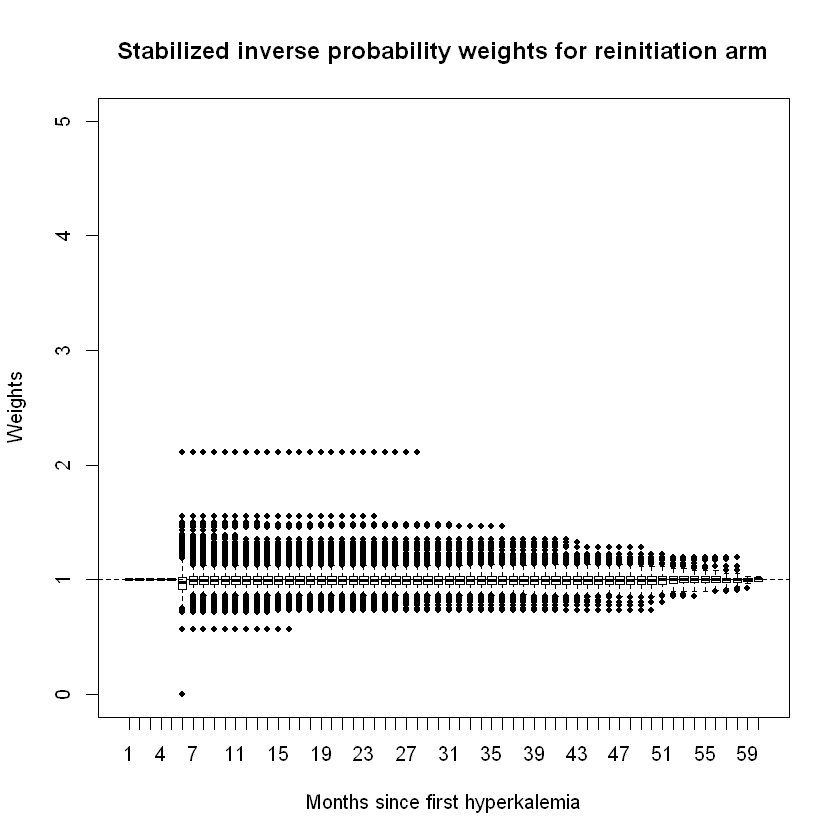

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.124   1.151   1.217   4.637 

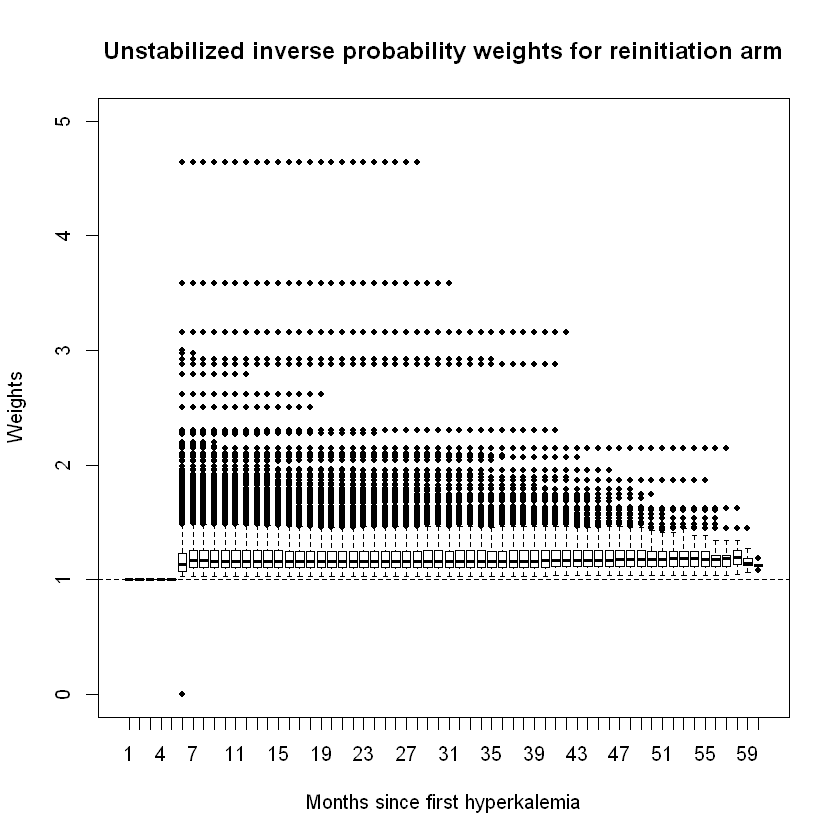

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9923  1.0000  1.0000 

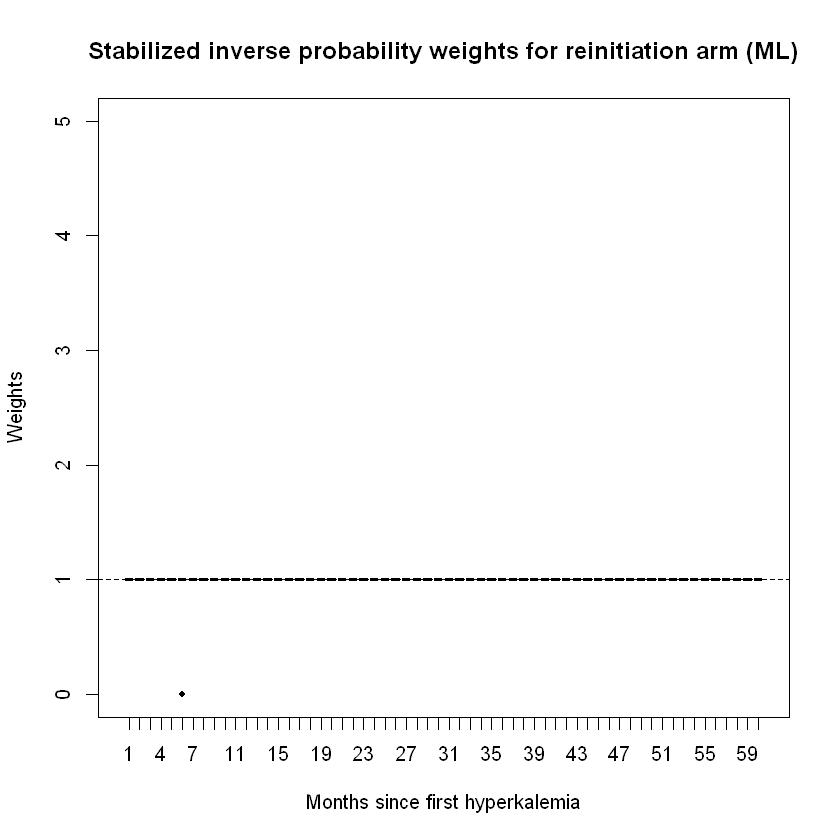

In [22]:
regression_formula_IPCW <- as.formula(paste0('censor ~ ', 
                                             paste(x_adjusted_var, collapse = " + "), 
                                             sep = ' '))
denominator.fit <- glm(regression_formula_IPCW, 
                       data = dta_clone_cataract_imp1_reinitiation_censor_part, 
                       family  = binomial(link = "logit"))
numerator.fit <- glm(censor ~ age + female + index_year + duration + potassium_value + 
                     primary_care_num + outpatient_num + inpatient_num + 
                     cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                     cov_cancer_t0 + cov_COPD_t0 + 
                     cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                     cov_MRA_t0 + cov_SPS_t0 + 
                     cov_statin_t0 + 
                     cov_antiplatelet_agent_t0 + 
                     cov_egfr_t0 + 
                     cov_hospitalization_t0, 
                     data = dta_clone_cataract_imp1_reinitiation_censor_part, 
                     family  = binomial(link = "logit"))
## machine learning formula
ML_formula_IPCW <- as.formula(paste0('censor ~ ', 
                                     paste(x_adjusted_var_ML, collapse = " + "), 
                                     sep = ' '))
denominator.fit_ML <- rpart(ML_formula_IPCW, 
                         data = dta_clone_cataract_imp1_reinitiation_censor_part, 
                         method = 'class')
numerator.fit_ML <- rpart(censor ~ age + female + index_year + duration + potassium_value  + 
                          primary_care_num + outpatient_num + inpatient_num + 
                          cov_diabetes_t0 + cov_hypertension_t0 + 
                          cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                          cov_cancer_t0 + cov_COPD_t0 + 
                          cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                          cov_MRA_t0 + cov_SPS_t0 + 
                          cov_statin_t0 + 
                          cov_antiplatelet_agent_t0 + 
                          cov_egfr_t0 + 
                          cov_hospitalization_t0, 
                          data = dta_clone_cataract_imp1_reinitiation_censor_part, 
                          method = 'class')
## =============================================================================================================
## Stabilized IPW
dta_clone_cataract_imp1_reinitiation_censor_part$ipw_per_month <- 
    ifelse(dta_clone_cataract_imp1_reinitiation_censor_part$censor == 1, 
           0, 
           (1 - fitted(numerator.fit)) / (1 - fitted(denominator.fit)))
dta_clone_cataract_imp1_reinitiation_noncensor_part$ipw_per_month <- 1
## =============================================================================================================
## Unstabilized IPW
dta_clone_cataract_imp1_reinitiation_censor_part$ipw_uns_per_month <- 
    ifelse(dta_clone_cataract_imp1_reinitiation_censor_part$censor == 1, 
           0, 
           1 / (1 - fitted(denominator.fit)))
dta_clone_cataract_imp1_reinitiation_noncensor_part$ipw_uns_per_month <- 1
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_cataract_imp1_reinitiation_censor_part$ipw_ML_per_month <- 
    ifelse(dta_clone_cataract_imp1_reinitiation_censor_part$censor == 1, 
           0, 
           predict(numerator.fit_ML)[, 1] / predict(denominator.fit_ML)[, 1])
dta_clone_cataract_imp1_reinitiation_noncensor_part$ipw_ML_per_month <- 1
## =============================================================================================================
dta_clone_cataract_imp1_reinitiation <- rbind(dta_clone_cataract_imp1_reinitiation_censor_part, 
                                           dta_clone_cataract_imp1_reinitiation_noncensor_part) %>% 
    arrange(ID, index_date)
## Stabilized IPW
dta_clone_cataract_imp1_reinitiation$ipw <- unlist(tapply(dta_clone_cataract_imp1_reinitiation$ipw_per_month, 
                                                       dta_clone_cataract_imp1_reinitiation$ID, cumprod))
## =============================================================================================================
## Unstabilized IPW
dta_clone_cataract_imp1_reinitiation$ipw_uns <- unlist(tapply(dta_clone_cataract_imp1_reinitiation$ipw_uns_per_month, 
                                                           dta_clone_cataract_imp1_reinitiation$ID, cumprod))
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_cataract_imp1_reinitiation$ipw_ML <- unlist(tapply(dta_clone_cataract_imp1_reinitiation$ipw_ML_per_month, 
                                                          dta_clone_cataract_imp1_reinitiation$ID, cumprod))
## =============================================================================================================
ipwplot(dta_clone_cataract_imp1_reinitiation$ipw, dta_clone_cataract_imp1_reinitiation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for reinitiation arm', 
        ylim = c(0, 5))
summary(dta_clone_cataract_imp1_reinitiation$ipw)
ipwplot(dta_clone_cataract_imp1_reinitiation$ipw_uns, dta_clone_cataract_imp1_reinitiation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Unstabilized inverse probability weights for reinitiation arm', 
        ylim = c(0, 5))
summary(dta_clone_cataract_imp1_reinitiation$ipw_uns)
ipwplot(dta_clone_cataract_imp1_reinitiation$ipw_ML, dta_clone_cataract_imp1_reinitiation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for reinitiation arm (ML)', 
        ylim = c(0, 5))
summary(dta_clone_cataract_imp1_reinitiation$ipw_ML)

In [23]:
## truncate unstabilized weight at 10
ipw.truncation <- function(ipw.weights, trunc.u = 10, trunc.l = 0) {
    weights.trunc.temp <- ifelse(ipw.weights >= trunc.u, trunc.u, ipw.weights) 
    weights.trunc <- ifelse(weights.trunc.temp <= trunc.l, trunc.l, weights.trunc.temp) 
}

In [24]:
dta_clone_cataract_imp1 <- rbind(dta_clone_cataract_imp1_discontinuation, dta_clone_cataract_imp1_reinitiation) %>% 
    arrange(ID, index_date)

In [25]:
dta_clone_cataract_imp1$ipw_uns_trunc <- ipw.truncation(dta_clone_cataract_imp1$ipw_uns, 
                                                     trunc.u = quantile(dta_clone_cataract_imp1$ipw_uns, 0.99))

## description of chracteristics at month 6 and cataract event in each arm (weighted)

In [26]:
dta_clone_cataract_6_month_weighted <- dta_clone_cataract %>% 
    left_join(dta_clone_cataract_imp1[ , c('ID', 'rank', 'ipw_uns_trunc')], by = c('ID', 'rank')) %>% 
    filter(rank == 6)

In [27]:
dta_clone_cataract_6_month_weighted <- svydesign(ids = ~ ID, 
                                              data = dta_clone_cataract_6_month_weighted, 
                                              weights = ~ dta_clone_cataract_6_month_weighted$ipw_uns_trunc)

In [28]:
tb1.part_weighted <- svyCreateTableOne(xvars, strata = 'X', data = dta_clone_cataract_6_month_weighted, factorVars = xfactorvars, includeNA = T)
tb1.part_weighted <- print(tb1.part_weighted, nonnormal = xnonnormvars, test = F, smd = T, printToggle = F)

In [29]:
tb1 <- cbind(tb1.part, tb1.part_weighted)

In [30]:
tb1_SMD_summary <- tb1[ , c(3, 6)] %>% data.frame() %>% filter(SMD != '') %>% 
    mutate(SMD = as.numeric(as.character(SMD)), 
           SMD.1 = as.numeric(ifelse(as.character(SMD.1) == '<0.001', '0.001', as.character(SMD.1)))) %>% 
    mutate(covariates = str_replace(
        str_replace(
            str_replace(
                str_replace_all(xvars, '_', ' '), 
                'cov ', ''), 
            'cat', 'categories'), 
        'num', 'number within 1 year prior')) %>% 
    mutate(covariates = factor(covariates, levels = rev(covariates)))

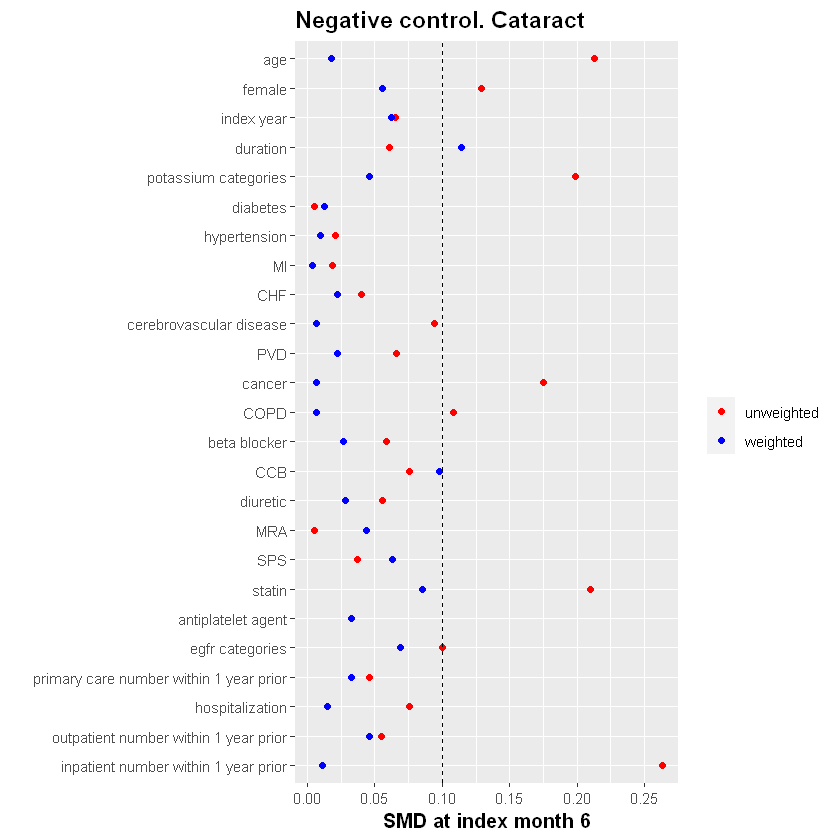

In [31]:
ggplot(data = tb1_SMD_summary, aes(x = SMD, y = covariates)) + 
    geom_point(aes(color = 'unweighted')) + 
    geom_point(aes(x = SMD.1, y = covariates, color = 'weighted')) + 
    scale_x_continuous(breaks = seq(0, 0.3, by = 0.05)) + 
    labs(title = 'Negative control. Cataract', x = 'SMD at index month 6', y = '') +   
    geom_vline(xintercept = 0.1, linetype = "dashed", color = "black") + 
    theme(plot.title = element_text(size = 14, face = "bold"), 
          axis.title = element_text(size = 12, face = "bold")) + 
    scale_colour_manual("", values = c("unweighted" = "red", "weighted" = "blue"))

In [32]:
tb1

,discontinuation,reinitiation,SMD,discontinuation,reinitiation,SMD
n,893,4543,,4144.24,4546.54,
age (mean (SD)),74.17 (13.16),71.35 (13.31),0.213,71.59 (13.77),71.35 (13.23),0.018
female = 1 (%),452 (50.6),2007 (44.2),0.129,1949.4 (47.0),2012.1 (44.3),0.056
index_year (%),,,0.065,,,0.062
2007,115 (12.9),494 (10.9),,514.5 (12.4),496.3 (10.9),
2008,196 (21.9),1019 (22.4),,963.4 (23.2),1016.9 (22.4),
2009,242 (27.1),1229 (27.1),,1125.0 (27.1),1231.3 (27.1),
2010,217 (24.3),1163 (25.6),,1000.2 (24.1),1164.2 (25.6),
2011,123 (13.8),638 (14.0),,541.2 (13.1),637.8 (14.0),
duration (median [IQR]),"7.00 [2.00, 18.00]","8.00 [2.00, 19.00]",0.061,"6.00 [2.00, 17.00]","8.00 [2.00, 19.00]",0.114


In [33]:
incid_num_weighted <- function(data = dta_clone_cataract_imp1, weights = 'ipw_uns_trunc') {
    dta <- data %>% mutate(weights = data[[weights]]) %>% 
        arrange(ID, index_date) %>% 
        group_by(ID) %>% 
        summarise(tstart = as.Date('1970-01-01'), 
                  tstop = as.Date('1970-01-01') + sum(weights) * 30, 
                  outcome_cataract = sum(outcome_cataract * weights), 
                  X = first(X)) %>% 
        ungroup() %>% 
        group_by(X) %>% 
        summarise(n = length(ID), 
                  median.followup = round(median(time_length(difftime(tstop, tstart), 'year')), 2), 
                  q25.followup = round(quantile(time_length(difftime(tstop, tstart), 'year'), 0.25), 2), 
                  q75.followup = round(quantile(time_length(difftime(tstop, tstart), 'year'), 0.75), 2), 
                  weighted_followup = paste0(median.followup, " [", q25.followup, "-", q75.followup, "]"), 
                  weighted_event = round(sum(outcome_cataract), 0), 
                  weighted_person_years = round(sum(time_length(difftime(tstop, tstart), 'year')), 2)) %>% 
        dplyr::select(c('X', 'n', 'weighted_followup', 'weighted_event', 'weighted_person_years'))
    return(dta)
} 
incid_num_weighted()

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


X,n,weighted_followup,weighted_event,weighted_person_years
discontinuation,5669,0.14 [0-0.48],378,8980.14
reinitiation,5669,1.33 [0.41-2.85],390,9995.65


## causal effect estimation

In [34]:
dta_clone_cataract_imp1 <- dta_clone_cataract_imp1 %>% mutate(X = ifelse(X == 'reinitiation', 0, 1))

In [35]:
causal_effect_estimation <- function(data = dta_clone_cataract_imp1, weights = 'ipw', 
                                     xvar = c('age', 'female', 'index_year', 'duration', 'potassium_value',
                                              'primary_care_num', 'outpatient_num', 'inpatient_num', 
                                              'cov_diabetes_t0', 'cov_hypertension_t0', 
                                              'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                                              'cov_cancer_t0', 'cov_COPD_t0', 
                                              'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                                              'cov_statin_t0', 
                                              'cov_antiplatelet_agent_t0', 
                                              'cov_egfr_t0', 
                                              'cov_hospitalization_t0')) {
    regression_formula <- as.formula(ifelse(length(xvar) == 0, 'outcome_cataract ~ X + rms::rcs(rank, 3)', 
                                            paste('outcome_cataract ~ X + rms::rcs(rank, 3) +', 
                                                  paste(xvar, collapse = ' + '), sep = ' ')))
    regression_formula_int <- as.formula(ifelse(length(xvar) == 0, 'outcome_cataract ~ X * rms::rcs(rank, 3)', 
                                                paste('outcome_cataract ~ X * rms::rcs(rank, 3) +', 
                                                      paste(xvar, collapse = ' + '), sep = ' ')))
    cataract.logistic.adjusted <- parglm(regression_formula, 
                                      weights = data[[weights]], 
                                      data = data, 
                                      family = binomial(link = "logit"), 
                                      control = parglm.control(nthreads = 6))
    cataract.logistic.adjusted_int <- parglm(regression_formula_int, 
                                          weights = data[[weights]], 
                                          data = data, 
                                          family = binomial(link = "logit"), 
                                          control = parglm.control(nthreads = 6)) 
    cataract.res.adjusted <- summary(cataract.logistic.adjusted)
    n_month = 60 
    cataract_risk_summary_discontinuation <- data %>% 
        filter(rank == 1) %>% 
        mutate(X = 1) %>% 
        dplyr::select(c('ID', 'X', 'rank', xvar)) %>% 
        slice(rep(row_number(), n_month)) %>% 
        arrange(ID) %>% 
        group_by(ID) %>% 
        mutate(rank = cumsum(rank)) %>% 
        ungroup()
    cataract_risk_summary_discontinuation$p_cataract = predict(cataract.logistic.adjusted_int, 
                                                         cataract_risk_summary_discontinuation, 
                                                         type = 'response')
    cataract_risk_summary_discontinuation <- cataract_risk_summary_discontinuation %>%
        mutate(p_surv = 1 - p_cataract) %>% 
        group_by(ID) %>% 
        mutate(p_cumsurv = cumprod(p_surv), 
               p_cumcataract = 1 - p_cumsurv) %>% 
        ungroup() %>% 
        group_by(rank) %>% 
        summarise(p_cumsurv = mean(p_cumsurv), 
                  p_cumcataract = mean(p_cumcataract)) %>% 
        mutate(X = 'discontinuation')
    cataract_risk_summary_reinitiation <- data %>% 
        filter(rank == 1) %>% 
        mutate(X = 0) %>% 
        dplyr::select(c('ID', 'X', 'rank', xvar)) %>% 
        slice(rep(row_number(), n_month)) %>% 
        arrange(ID) %>% 
        group_by(ID) %>% 
        mutate(rank = cumsum(rank)) %>% 
        ungroup()
    cataract_risk_summary_reinitiation$p_cataract = predict(cataract.logistic.adjusted_int, 
                                                      cataract_risk_summary_reinitiation, 
                                                      type = 'response')
    cataract_risk_summary_reinitiation <- cataract_risk_summary_reinitiation %>%
        mutate(p_surv = 1 - p_cataract) %>% 
        group_by(ID) %>% 
        mutate(p_cumsurv = cumprod(p_surv), 
               p_cumcataract = 1 - p_cumsurv) %>% 
        ungroup() %>% 
        group_by(rank) %>% 
        summarise(p_cumsurv = mean(p_cumsurv), 
                  p_cumcataract = mean(p_cumcataract)) %>% 
        mutate(X = 'reinitiation')
    cataract_risk_summary <- rbind(cataract_risk_summary_discontinuation, cataract_risk_summary_reinitiation)
    risk_discontinuation_3_y <- cataract_risk_summary_discontinuation %>% 
        filter(rank == 36) %>% 
        dplyr::select(p_cumcataract) %>% as.numeric()
    risk_reinitiation_3_y <- cataract_risk_summary_reinitiation %>% 
        filter(rank == 36) %>% 
        dplyr::select(p_cumcataract) %>% as.numeric()
    RD <- (risk_discontinuation_3_y - risk_reinitiation_3_y) * 100
    RR <- (risk_discontinuation_3_y / risk_reinitiation_3_y)
    risk_res <- round(c(risk_discontinuation_3_y * 100, risk_reinitiation_3_y * 100, RD, RR, 
                        exp(cataract.res.adjusted$coefficients[2, 1])), 2)
    names(risk_res) <- c('3 year risk for discontinuation (%)', 
                         '3 year risk for reinitiation (%)', 
                         'risk difference (%)', 
                         'risk ratio', 
                         'hazard ratio')
    risk_res <- risk_res %>% t()
    risk_res <- list(risk_res, cataract_risk_summary)
    return(risk_res)
}

In [36]:
main_res = causal_effect_estimation(data = dta_clone_cataract_imp1, weights = 'ipw_uns_trunc', 
                                    xvar = c('duration'))
main_point_estimation <- main_res[[1]]
main_cum_incidence <- main_res[[2]]

Note: Using an external vector in selections is ambiguous.
i Use `all_of(xvar)` instead of `xvar` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


In [37]:
main_point_estimation

3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
9.88,9.1,0.79,1.09,1.08


In [35]:
data_sample_generation <- function(k = 1, data = dta_clone_cataract_imp1) {
    set.seed(k)
    data_discontinuation <- data %>% filter(X == 1)
    ID_random_sample_discontinuation <- sample(unique(data_discontinuation$ID), 
                                               size = length(unique(data_discontinuation$ID)), 
                                               replace = T) 
    ID_random_sample_reinitiation <- ID_random_sample_discontinuation + length(ID_random_sample_discontinuation)
    ID_random_sample <- c(ID_random_sample_discontinuation, ID_random_sample_reinitiation)
    sub_data <- function(i, j = 1) {
        dta <- data %>% filter(ID == i) %>% mutate(ID = j) %>% data.frame()
        return(dta)
    }
    dataset_random_sample <- rbindlist(mapply(sub_data, ID_random_sample,  1 : length(ID_random_sample), SIMPLIFY = F))
    return(dataset_random_sample)
}

In [36]:
bootstrap_sub <- function (data = dta_clone_cataract_imp1, weights = 'ipw_uns_trunc', 
    xvar_boot = c('duration'), k = 1) {
    no_of_sample = 50
    CI_res_sub <- mclapply ((1 + (k - 1) * no_of_sample) : (k * no_of_sample), function(j) {
        dataset_random_sample <- data_sample_generation(j, data = data)
        Sys.sleep((j - (k - 1) * no_of_sample) * 5)
        causal_effect_estimation(data = dataset_random_sample, weights = weights, 
                                 xvar = xvar_boot)}, mc.cores = 50)   
    CI_res_sub <- foreach (i = 1 : no_of_sample, .combine = c) %do% {
        CI_res_sub[[i]]
    }
    return(CI_res_sub)
}

In [37]:
CI_res <- foreach (i = 1 : 10, .combine = c) %do% {
    bootstrap_sub(k = i)
}

In [38]:
no_of_sample = 500
CI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
    CI_res[[i]]
}
CI_point_estimation <- CI_point_estimation %>% data.frame()
colnames(CI_point_estimation) <- c('risk_dis', 'risk_re', 'RD', 'RR', 'HR')
CI_point_estimation <- CI_point_estimation %>% 
    summarise(lci_risk_dis = quantile(risk_dis, 0.025), 
              uci_risk_dis = quantile(risk_dis, 0.975), 
              lci_risk_re = quantile(risk_re, 0.025), 
              uci_risk_re = quantile(risk_re, 0.975), 
              lci_RD = quantile(RD, 0.025), 
              uci_RD = quantile(RD, 0.975), 
              lci_RR = quantile(RR, 0.025), 
              uci_RR = quantile(RR, 0.975), 
              lci_HR = quantile(HR, 0.025), 
              uci_HR = quantile(HR, 0.975))
CI_point_estimation <- round(matrix(as.numeric(CI_point_estimation), nrow = 5, ncol = 2, byrow = T), 2)
causal_effect_point_estimation <- paste(t(main_point_estimation), 
                                        ' (', CI_point_estimation[ , 1], '-', 
                                        CI_point_estimation[ , 2], ')', sep = '')
names(causal_effect_point_estimation) <- colnames(main_point_estimation)
main_res <- t(causal_effect_point_estimation)
main_res

3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
25.79 (21.87-30.23),17.27 (15.72-18.96),8.52 (4.43-13.17),1.49 (1.25-1.81),1.49 (1.32-1.72)


In [39]:
CI_cum_incidence <- foreach (i = seq(2, 2 * no_of_sample, 2), .combine = cbind) %do% {
    CI_res[[i]]
}
CI_cum_incidence <- CI_cum_incidence[ , c(c(1, 4), seq(3, no_of_sample * 4, 4))]

In [40]:
CI_cum_incidence <- CI_cum_incidence %>% 
    gather(i, p_cumcataract, p_cumcataract : p_cumcataract.499, factor_key = TRUE) %>% ## Note!!!!
    arrange(rank, X) %>% 
    group_by(rank, X) %>% 
    summarise(lci_p_cumcataract = quantile(p_cumcataract, 0.025), 
              uci_p_cumcataract = quantile(p_cumcataract, 0.975))

`summarise()` regrouping output by 'rank' (override with `.groups` argument)



In [41]:
main_cum_incidence <- rbind(data.frame(rank = 0, p_cumsurv = 1, p_cumcataract = 0, X = 'discontinuation'), 
                            data.frame(rank = 0, p_cumsurv = 1, p_cumcataract = 0, X = 'reinitiation'), 
                            data.frame(main_cum_incidence))

In [42]:
CI_cum_incidence <- rbind(data.frame(rank = 0, X = 'discontinuation', lci_p_cumcataract = 0, uci_p_cumcataract = 0), 
                          data.frame(rank = 0, X = 'reinitiation', lci_p_cumcataract = 0, uci_p_cumcataract = 0), 
                          data.frame(CI_cum_incidence))

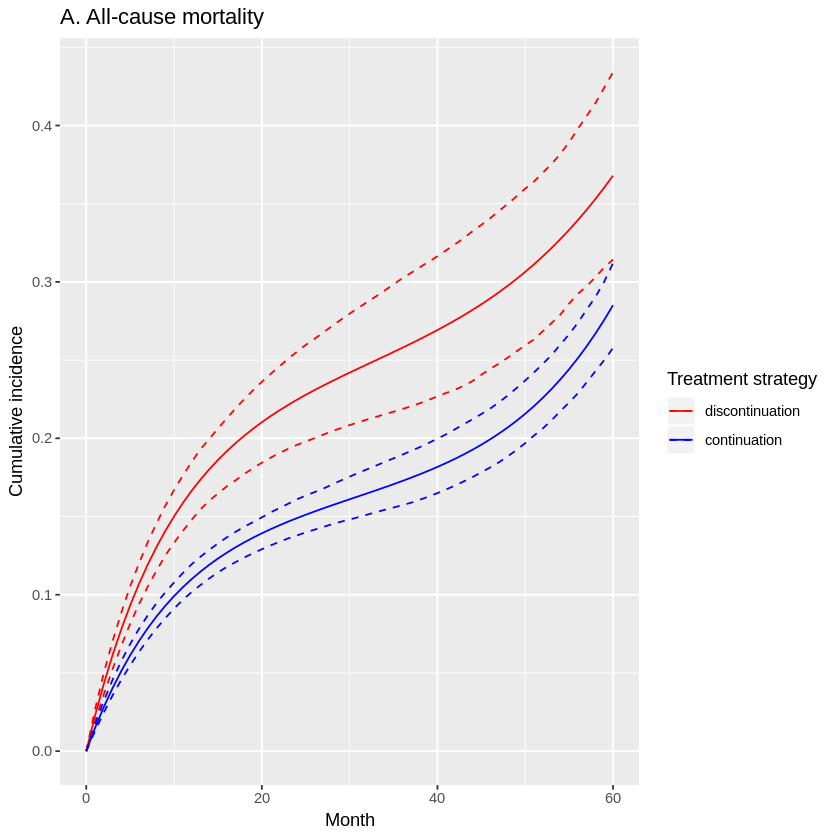

In [45]:
ggplot(data = main_cum_incidence, aes(x = rank, y = p_cumcataract, group = X, colour = X)) + 
    geom_line() + 
    geom_line(data = CI_cum_incidence, aes(x = rank, y = lci_p_cumcataract, group = X, colour = X), 
              linetype = "dashed") + 
    geom_line(data = CI_cum_incidence, aes(x = rank, y = uci_p_cumcataract, group = X, colour = X), 
              linetype = "dashed") + 
    xlab('Month') + 
    ylab('Cumulative incidence') + 
    labs(title = 'Negative control. Cataract', color = "Treatment strategy") + 
    scale_color_manual(labels=c("discontinuation","continuation"),
                       values=c("red", "blue"))

## Sensitivity analyses

### <font face = "Times New Roman" color='blue'>stabilized IPWs without truncation</font>

In [38]:
incid_num_weighted(weights = 'ipw')

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


X,n,weighted_followup,weighted_event,weighted_person_years
0,5669,1.18 [0.41-2.44],335,8623.68
1,5669,0.08 [0-0.23],95,2103.43


In [39]:
sen1_res = causal_effect_estimation(weights = 'ipw')
sen1_point_estimation <- sen1_res[[1]]

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


In [40]:
sen1_point_estimation

3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
9.75,9.08,0.68,1.07,1


In [50]:
CI_res <- foreach (i = 1 : 10, .combine = c) %do% {
    bootstrap_sub(k = i, weights = 'ipw', 
                  xvar_boot = c('age', 'female', 'index_year', 'duration', 'potassium_value',
                                'primary_care_num', 'outpatient_num', 'inpatient_num', 
                                'cov_diabetes_t0', 'cov_hypertension_t0', 
                                'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                                'cov_cancer_t0', 'cov_COPD_t0', 
                                'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                                'cov_statin_t0', 
                                'cov_antiplatelet_agent_t0', 
                                'cov_egfr_t0', 
                                'cov_hospitalization_t0'))
}

In [51]:
################################################################################################
CI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
    CI_res[[i]]
}
CI_point_estimation <- CI_point_estimation %>% data.frame()
colnames(CI_point_estimation) <- c('risk_dis', 'risk_re', 'RD', 'RR', 'HR')
CI_point_estimation <- CI_point_estimation %>% 
    summarise(lci_risk_dis = quantile(risk_dis, 0.025), 
              uci_risk_dis = quantile(risk_dis, 0.975), 
              lci_risk_re = quantile(risk_re, 0.025), 
              uci_risk_re = quantile(risk_re, 0.975), 
              lci_RD = quantile(RD, 0.025), 
              uci_RD = quantile(RD, 0.975), 
              lci_RR = quantile(RR, 0.025), 
              uci_RR = quantile(RR, 0.975), 
              lci_HR = quantile(HR, 0.025), 
              uci_HR = quantile(HR, 0.975))
CI_point_estimation <- round(matrix(as.numeric(CI_point_estimation), nrow = 5, ncol = 2, byrow = T), 2)
causal_effect_point_estimation <- paste(t(sen1_point_estimation), 
                                        ' (', CI_point_estimation[ , 1], '-', 
                                        CI_point_estimation[ , 2], ')', sep = '')
names(causal_effect_point_estimation) <- colnames(sen1_point_estimation)
t(causal_effect_point_estimation)

3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
23 (20.11-26.29),18.19 (16.57-19.98),4.81 (1.58-8.16),1.26 (1.08-1.46),1.48 (1.34-1.65)


### <font face = "Times New Roman" color='blue'>stabilized IPWs by ML</font>

In [37]:
incid_num_weighted(weights = 'ipw_ML')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



X,n,weighted_followup,weighted_event,weighted_person_years
<dbl>,<int>,<chr>,<dbl>,<dbl>
0,4720,1.4 [0.41-2.71],709,7925.26
1,4720,0.08 [0-0.25],388,1788.58


In [38]:
sen2_res = causal_effect_estimation(weights = 'ipw_ML')
sen2_point_estimation <- sen2_res[[1]]

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [39]:
CI_res <- foreach (i = 1 : 10, .combine = c) %do% {
    bootstrap_sub(k = i, weights = 'ipw_ML', 
                  xvar_boot = c('age', 'female', 'index_year', 'duration', 'potassium_value',
                                'primary_care_num', 'outpatient_num', 'inpatient_num', 
                                'cov_diabetes_t0', 'cov_hypertension_t0', 
                                'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                                'cov_cancer_t0', 'cov_COPD_t0', 
                                'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                                'cov_statin_t0', 
                                'cov_antiplatelet_agent_t0', 
                                'cov_egfr_t0', 
                                'cov_hospitalization_t0'))
}
no_of_sample = 500
################################################################################################
CI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
    CI_res[[i]]
}
CI_point_estimation <- CI_point_estimation %>% data.frame()
colnames(CI_point_estimation) <- c('risk_dis', 'risk_re', 'RD', 'RR', 'HR')
CI_point_estimation <- CI_point_estimation %>% 
    summarise(lci_risk_dis = quantile(risk_dis, 0.025), 
              uci_risk_dis = quantile(risk_dis, 0.975), 
              lci_risk_re = quantile(risk_re, 0.025), 
              uci_risk_re = quantile(risk_re, 0.975), 
              lci_RD = quantile(RD, 0.025), 
              uci_RD = quantile(RD, 0.975), 
              lci_RR = quantile(RR, 0.025), 
              uci_RR = quantile(RR, 0.975), 
              lci_HR = quantile(HR, 0.025), 
              uci_HR = quantile(HR, 0.975))
CI_point_estimation <- round(matrix(as.numeric(CI_point_estimation), nrow = 5, ncol = 2, byrow = T), 2)
causal_effect_point_estimation <- paste(t(sen2_point_estimation), 
                                        ' (', CI_point_estimation[ , 1], '-', 
                                        CI_point_estimation[ , 2], ')', sep = '')
names(causal_effect_point_estimation) <- colnames(sen2_point_estimation)
t(causal_effect_point_estimation)

3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
23.61 (20.65-26.93),18.05 (16.41-19.82),5.55 (2.28-9.13),1.31 (1.12-1.51),1.52 (1.38-1.69)


### <font face = "Times New Roman" color='blue'>albuminuria included as a time-varying confounder</font>

In [40]:
dta_clone_cataract_ALB <- dta_clone_cataract %>% 
    filter(!is.na(cov_acr_t0)) ## exclude patients with baseline missing albuminuria

In [41]:
length(unique(dta_clone_cataract_ALB$lopnr))

[1] 2036

In [42]:
x_adjusted_var_ALB <- c('age', 'female', 'index_year', 'rcs(duration, 3)', 'rcs(potassium_value, 3)', 
                        # 'cov_diabetes_t0', 'cov_hypertension_t0', 
                        # 'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                        # 'cov_COPD_t0', 
                        # 'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                        # 'cov_statin_t0', 
                        # 'cov_antiplatelet_agent_t0', 
                        # 'cov_egfr_t0', 
                        'primary_care_num', 
                        'outpatient_num', 
                        'inpatient_num', # 'cov_hospitalization_t0', 
                        'cov_diabetes', 'cov_hypertension', 
                        'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                        'cov_cancer', 'cov_COPD',  
                        'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                        'cov_statin', 
                        'cov_antiplatelet_agent', 
                        'rcs(cov_egfr, 6)', 
                        'rcs(cov_acr, 6)', 
                        # 'rcs(cov_potassium, 12)', 
                        'cov_hospitalization')

In [43]:
dta_clone_cataract_ALB_discontinuation <- dta_clone_cataract_ALB %>% 
    filter(X == 'discontinuation') %>% 
    arrange(ID, index_date)
dta_clone_cataract_ALB_discontinuation_censor_part <- dta_clone_cataract_ALB_discontinuation %>% 
    filter(rank %in% 1 : 6)
dta_clone_cataract_ALB_discontinuation_noncensor_part <- dta_clone_cataract_ALB_discontinuation %>% 
    filter(rank > 6)
## logistic regression formula
regression_formula_IPCW <- as.formula(paste0('censor ~ rank + rank ^ 2 + ', 
                                             paste(x_adjusted_var, collapse = " + "), 
                                             sep = ' '))
denominator.fit <- glm(regression_formula_IPCW, 
                       data = dta_clone_cataract_ALB_discontinuation_censor_part, 
                       family  = binomial(link = "logit"))
## ===============================================================================================================
## Unstabilized IPW
dta_clone_cataract_ALB_discontinuation_censor_part$ipw_uns_per_month <- 
    ifelse(dta_clone_cataract_ALB_discontinuation_censor_part$censor == 1, 
           0, 
           1 / (1 - fitted(denominator.fit)))
dta_clone_cataract_ALB_discontinuation_noncensor_part$ipw_uns_per_month <- 1
## ===============================================================================================================
dta_clone_cataract_ALB_discontinuation <- rbind(dta_clone_cataract_ALB_discontinuation_censor_part, 
                                             dta_clone_cataract_ALB_discontinuation_noncensor_part) %>% 
    arrange(ID, index_date)
## Unstabilized IPW
dta_clone_cataract_ALB_discontinuation$ipw_uns <- unlist(tapply(dta_clone_cataract_ALB_discontinuation$ipw_uns_per_month, 
                                                             dta_clone_cataract_ALB_discontinuation$ID, cumprod))
## =============================================================================================================

In [44]:
dta_clone_cataract_ALB_reinitiation <- dta_clone_cataract_ALB %>% 
    filter(X == 'reinitiation') %>% 
    arrange(ID, index_date)
dta_clone_cataract_ALB_reinitiation_censor_part <- dta_clone_cataract_ALB_reinitiation %>% 
    filter(rank == 6)
dta_clone_cataract_ALB_reinitiation_noncensor_part <- dta_clone_cataract_ALB_reinitiation %>% 
    filter(rank %in% 1 : 5 | rank > 6)
regression_formula_IPCW <- as.formula(paste0('censor ~ ', 
                                             paste(x_adjusted_var, collapse = " + "), 
                                             sep = ' '))
denominator.fit <- glm(regression_formula_IPCW, 
                       data = dta_clone_cataract_ALB_reinitiation_censor_part, 
                       family  = binomial(link = "logit"))
## Unstabilized IPW
dta_clone_cataract_ALB_reinitiation_censor_part$ipw_uns_per_month <- 
    ifelse(dta_clone_cataract_ALB_reinitiation_censor_part$censor == 1, 
           0, 
           1 / (1 - fitted(denominator.fit)))
dta_clone_cataract_ALB_reinitiation_noncensor_part$ipw_uns_per_month <- 1
## =============================================================================================================
dta_clone_cataract_ALB_reinitiation <- rbind(dta_clone_cataract_ALB_reinitiation_censor_part, 
                                          dta_clone_cataract_ALB_reinitiation_noncensor_part) %>% 
    arrange(ID, index_date)
## Unstabilized IPW
dta_clone_cataract_ALB_reinitiation$ipw_uns <- unlist(tapply(dta_clone_cataract_ALB_reinitiation$ipw_uns_per_month, 
                                                          dta_clone_cataract_ALB_reinitiation$ID, cumprod))
## =============================================================================================================

In [45]:
dta_clone_cataract_ALB <- rbind(dta_clone_cataract_ALB_discontinuation, dta_clone_cataract_ALB_reinitiation) %>% 
    arrange(ID, index_date)
dta_clone_cataract_ALB$ipw_uns_trunc <- ipw.truncation(dta_clone_cataract_ALB$ipw_uns, 
                                                    trunc.u = quantile(dta_clone_cataract_ALB$ipw_uns, 0.99))
dta_clone_cataract_ALB <- dta_clone_cataract_ALB %>% mutate(X = ifelse(X == 'reinitiation', 0, 1))

In [46]:
incid_num_weighted(data = dta_clone_cataract_ALB, weights = 'ipw_uns_trunc')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



X,n,weighted_followup,weighted_event,weighted_person_years
<dbl>,<int>,<chr>,<dbl>,<dbl>
0,2036,1.57 [0.41-3],332,3796.12
1,2036,0.14 [0-0.45],423,3544.09


In [47]:
sen3_res = causal_effect_estimation(data = dta_clone_cataract_ALB, weights = 'ipw_uns_trunc', 
                                    xvar = c('duration'))
sen3_point_estimation <- sen3_res[[1]]
## bootstrap on 500 sample
CI_res <- foreach (i = 1 : 10, .combine = c) %do% {
    bootstrap_sub(data = dta_clone_cataract_ALB, k = i, weights = 'ipw_uns_trunc')
}
##############################################################################################################
CI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
    CI_res[[i]]
}
CI_point_estimation <- CI_point_estimation %>% data.frame()
colnames(CI_point_estimation) <- c('risk_dis', 'risk_re', 'RD', 'RR', 'HR')
CI_point_estimation <- CI_point_estimation %>% 
    summarise(lci_risk_dis = quantile(risk_dis, 0.025), 
              uci_risk_dis = quantile(risk_dis, 0.975), 
              lci_risk_re = quantile(risk_re, 0.025), 
              uci_risk_re = quantile(risk_re, 0.975), 
              lci_RD = quantile(RD, 0.025), 
              uci_RD = quantile(RD, 0.975), 
              lci_RR = quantile(RR, 0.025), 
              uci_RR = quantile(RR, 0.975), 
              lci_HR = quantile(HR, 0.025), 
              uci_HR = quantile(HR, 0.975))
CI_point_estimation <- round(matrix(as.numeric(CI_point_estimation), nrow = 5, ncol = 2, byrow = T), 2)
causal_effect_point_estimation <- paste(t(sen3_point_estimation), 
                                        ' (', CI_point_estimation[ , 1], '-', 
                                        CI_point_estimation[ , 2], ')', sep = '')
names(causal_effect_point_estimation) <- colnames(sen3_point_estimation)
t(causal_effect_point_estimation)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
20.72 (16.21-26.72),14.86 (9.76-19.18),5.86 (0.11-13.91),1.39 (1.01-2.24),1.37 (1-1.99)


## subgroup analysis

In [48]:
subgroup_analysis <- function(data = dta_clone_cataract_imp1, by = 'age_cat', 
                              xvar = c('duration')) {
    data1 = data[data[[by]] == 1, ]
    data0 = data[data[[by]] == 0, ]
    no_of_sample = 500
    ##################################################
    ### SUBGROUP 1 RESULTS
    ##################################################
    sub1_res = causal_effect_estimation(data = data1, weights = 'ipw_uns_trunc', 
                                        xvar = xvar)
    sub1_point_estimation <- sub1_res[[1]]
    ## bootstrap on 500 sample
    sub1_CI_res <- foreach (i = 1 : 10, .combine = c) %do% {
        bootstrap_sub(data = data1, k = i, weights = 'ipw_uns_trunc', xvar_boot = xvar)
    }
    ##############################################################################################
    sub1_CI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
        sub1_CI_res[[i]]
    }
    sub1_CI_point_estimation <- sub1_CI_point_estimation %>% data.frame()
    colnames(sub1_CI_point_estimation) <- c('risk_dis', 'risk_re', 'RD', 'RR', 'HR')
    sub1_CI_point_estimation <- sub1_CI_point_estimation %>% 
        summarise(lci_risk_dis = quantile(risk_dis, 0.025), 
                  uci_risk_dis = quantile(risk_dis, 0.975), 
                  lci_risk_re = quantile(risk_re, 0.025), 
                  uci_risk_re = quantile(risk_re, 0.975), 
                  lci_RD = quantile(RD, 0.025), 
                  uci_RD = quantile(RD, 0.975), 
                  lci_RR = quantile(RR, 0.025), 
                  uci_RR = quantile(RR, 0.975), 
                  lci_HR = quantile(HR, 0.025), 
                  uci_HR = quantile(HR, 0.975))
    sub1_CI_point_estimation <- round(matrix(as.numeric(sub1_CI_point_estimation), nrow = 5, ncol = 2, byrow = T), 2)
    causal_effect_point_estimation <- paste(t(sub1_point_estimation), 
                                            ' (', sub1_CI_point_estimation[ , 1], '-', 
                                            sub1_CI_point_estimation[ , 2], ')', sep = '')
    sub1_res <- t(causal_effect_point_estimation)
    ##################################################
    ### SUBGROUP 0 RESULTS
    ##################################################
    sub0_res = causal_effect_estimation(data = data0, weights = 'ipw_uns_trunc', 
                                        xvar = xvar)
    sub0_point_estimation <- sub0_res[[1]]
    ## bootstrap on 500 sample
    sub0_CI_res <- foreach (i = 1 : 10, .combine = c) %do% {
        bootstrap_sub(data = data0, k = i, weights = 'ipw_uns_trunc', xvar_boot = xvar)
    }
    ######################################################################################################
    sub0_CI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
        sub0_CI_res[[i]]
    }
    sub0_CI_point_estimation <- sub0_CI_point_estimation %>% data.frame()
    colnames(sub0_CI_point_estimation) <- c('risk_dis', 'risk_re', 'RD', 'RR', 'HR')
    sub0_CI_point_estimation <- sub0_CI_point_estimation %>% 
        summarise(lci_risk_dis = quantile(risk_dis, 0.025), 
                  uci_risk_dis = quantile(risk_dis, 0.975), 
                  lci_risk_re = quantile(risk_re, 0.025), 
                  uci_risk_re = quantile(risk_re, 0.975), 
                  lci_RD = quantile(RD, 0.025), 
                  uci_RD = quantile(RD, 0.975), 
                  lci_RR = quantile(RR, 0.025), 
                  uci_RR = quantile(RR, 0.975), 
                  lci_HR = quantile(HR, 0.025), 
                  uci_HR = quantile(HR, 0.975))
    sub0_CI_point_estimation <- round(matrix(as.numeric(sub0_CI_point_estimation), nrow = 5, ncol = 2, byrow = T), 2)
    causal_effect_point_estimation <- paste(t(sub0_point_estimation), 
                                            ' (', sub0_CI_point_estimation[ , 1], '-', 
                                            sub0_CI_point_estimation[ , 2], ')', sep = '')
    sub0_res <- t(causal_effect_point_estimation)
    #####################################################################################
    #####################################################################################
    AERI_point_estimation <- round(sub1_point_estimation[3] - sub0_point_estimation[3], 2)
    CI_AERI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
        sub1_CI_res[[i]][3] - sub0_CI_res[[i]][3]
    }
    CI_AERI_point_estimation <- CI_AERI_point_estimation %>% data.frame()
    colnames(CI_AERI_point_estimation) <- c('AERI')
    CI_AERI_point_estimation <- CI_AERI_point_estimation %>% 
        summarise(lci_AERI = round(quantile(AERI, 0.025), 2), 
                  uci_AERI = round(quantile(AERI, 0.975), 2))
    causal_effect_AERI <- c(AERI_point_estimation, CI_AERI_point_estimation[ , 1], CI_AERI_point_estimation[ , 2], 
                            paste(AERI_point_estimation, 
                                  ' (', CI_AERI_point_estimation[ , 1], '-', 
                                  CI_AERI_point_estimation[ , 2], ')', sep = ''))
    ### think about how to calcualte P value?????????
    p_res <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = c) %do% {
        sub1_CI_res[[i]][3] - sub0_CI_res[[i]][3]
    }
    p_more_than_0 <- sum(p_res > 0) / length(p_res)
    p_less_than_0 <- sum(p_res < 0) / length(p_res)
    p <- round(min(p_more_than_0, p_less_than_0) * 2, 2)
    res <- rbind(c(sub1_res, causal_effect_AERI, p), c(sub0_res, '', '', '', '', ''))
    colnames(res) <- c(colnames(sub1_point_estimation), 'AERI point', 'AERI lci', 'AERI uci', 'AERI', 'p')
    return(res)
}

In [49]:
### by age
dta_clone_cataract_imp1 <- dta_clone_cataract_imp1 %>% mutate(age_cat = ifelse(age >= 70, 1, 0))
sub_res_age <- subgroup_analysis(by = 'age_cat')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [50]:
### by sex
sub_res_sex <- subgroup_analysis(by = 'female')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [51]:
### by diabetes
sub_res_diabetes <- subgroup_analysis(by = 'cov_diabetes_t0')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [52]:
### by heart failure
sub_res_HF <- subgroup_analysis(by = 'cov_CHF_t0')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [53]:
### by eGFR
dta_clone_cataract_imp1 <- dta_clone_cataract_imp1 %>% mutate(cov_egfr_subcat_t0 = ifelse(cov_egfr_t0 >= 60, 1, 0))
sub_res_eGFR <- subgroup_analysis(by = 'cov_egfr_subcat_t0')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [68]:
sub_res <- rbind(sub_res_age, 
                 sub_res_sex, 
                 sub_res_diabetes, 
                 sub_res_HF, 
                 sub_res_eGFR) %>% data.frame()
sub_res <- sub_res %>% mutate(group = c(paste('    ', intToUtf8(8805), '70 years', sep = ''), 
                                        '    <70 years', 
                                        '    female', '    male', 
                                        '    yes', '    no', 
                                        '    yes', '    no', 
                                        paste('    ', intToUtf8(8805), '60 ml/min/1.73m^2', sep = ''), 
                                        '    <60 ml/min/1.73m^2')) %>% 
    dplyr::select(c(11, 1 : 10))
sub_res <- rbind(as.matrix(t(c('Overall', main_res, '', '', '', '', ''))), as.matrix(sub_res)) %>% 
    data.frame()
colnames(sub_res) <- c('group', colnames(sub_res_age))
sub_res <- sub_res %>% dplyr::select(c(1 : 4, 7 : 11)) %>% 
    tibble::add_row(group = 'Age', .before = 2) %>% 
    tibble::add_row(group = 'Sex', .before = 5) %>% 
    tibble::add_row(group = 'Diabetes', .before = 8) %>% 
    tibble::add_row(group = 'Heart failure', .before = 11) %>%  
    tibble::add_row(group = 'eGFR', .before = 14)

In [69]:
tabletext <- cbind(c("Subgroup", "\n", as.character(sub_res$group)), 
                   c("3 year risk for\n discontinuation (%)", "\n", as.character(sub_res[ , 2])), 
                   c("3 year risk for\n reinitiation (%)", "\n", as.character(sub_res[ , 3])), 
                   c("Risk difference (%)", "\n", as.character(sub_res[ , 4])), 
                   c("AERI (%)", "\n", as.character(sub_res$AERI)), 
                   c("P Value", "\n", as.character(sub_res$p)))

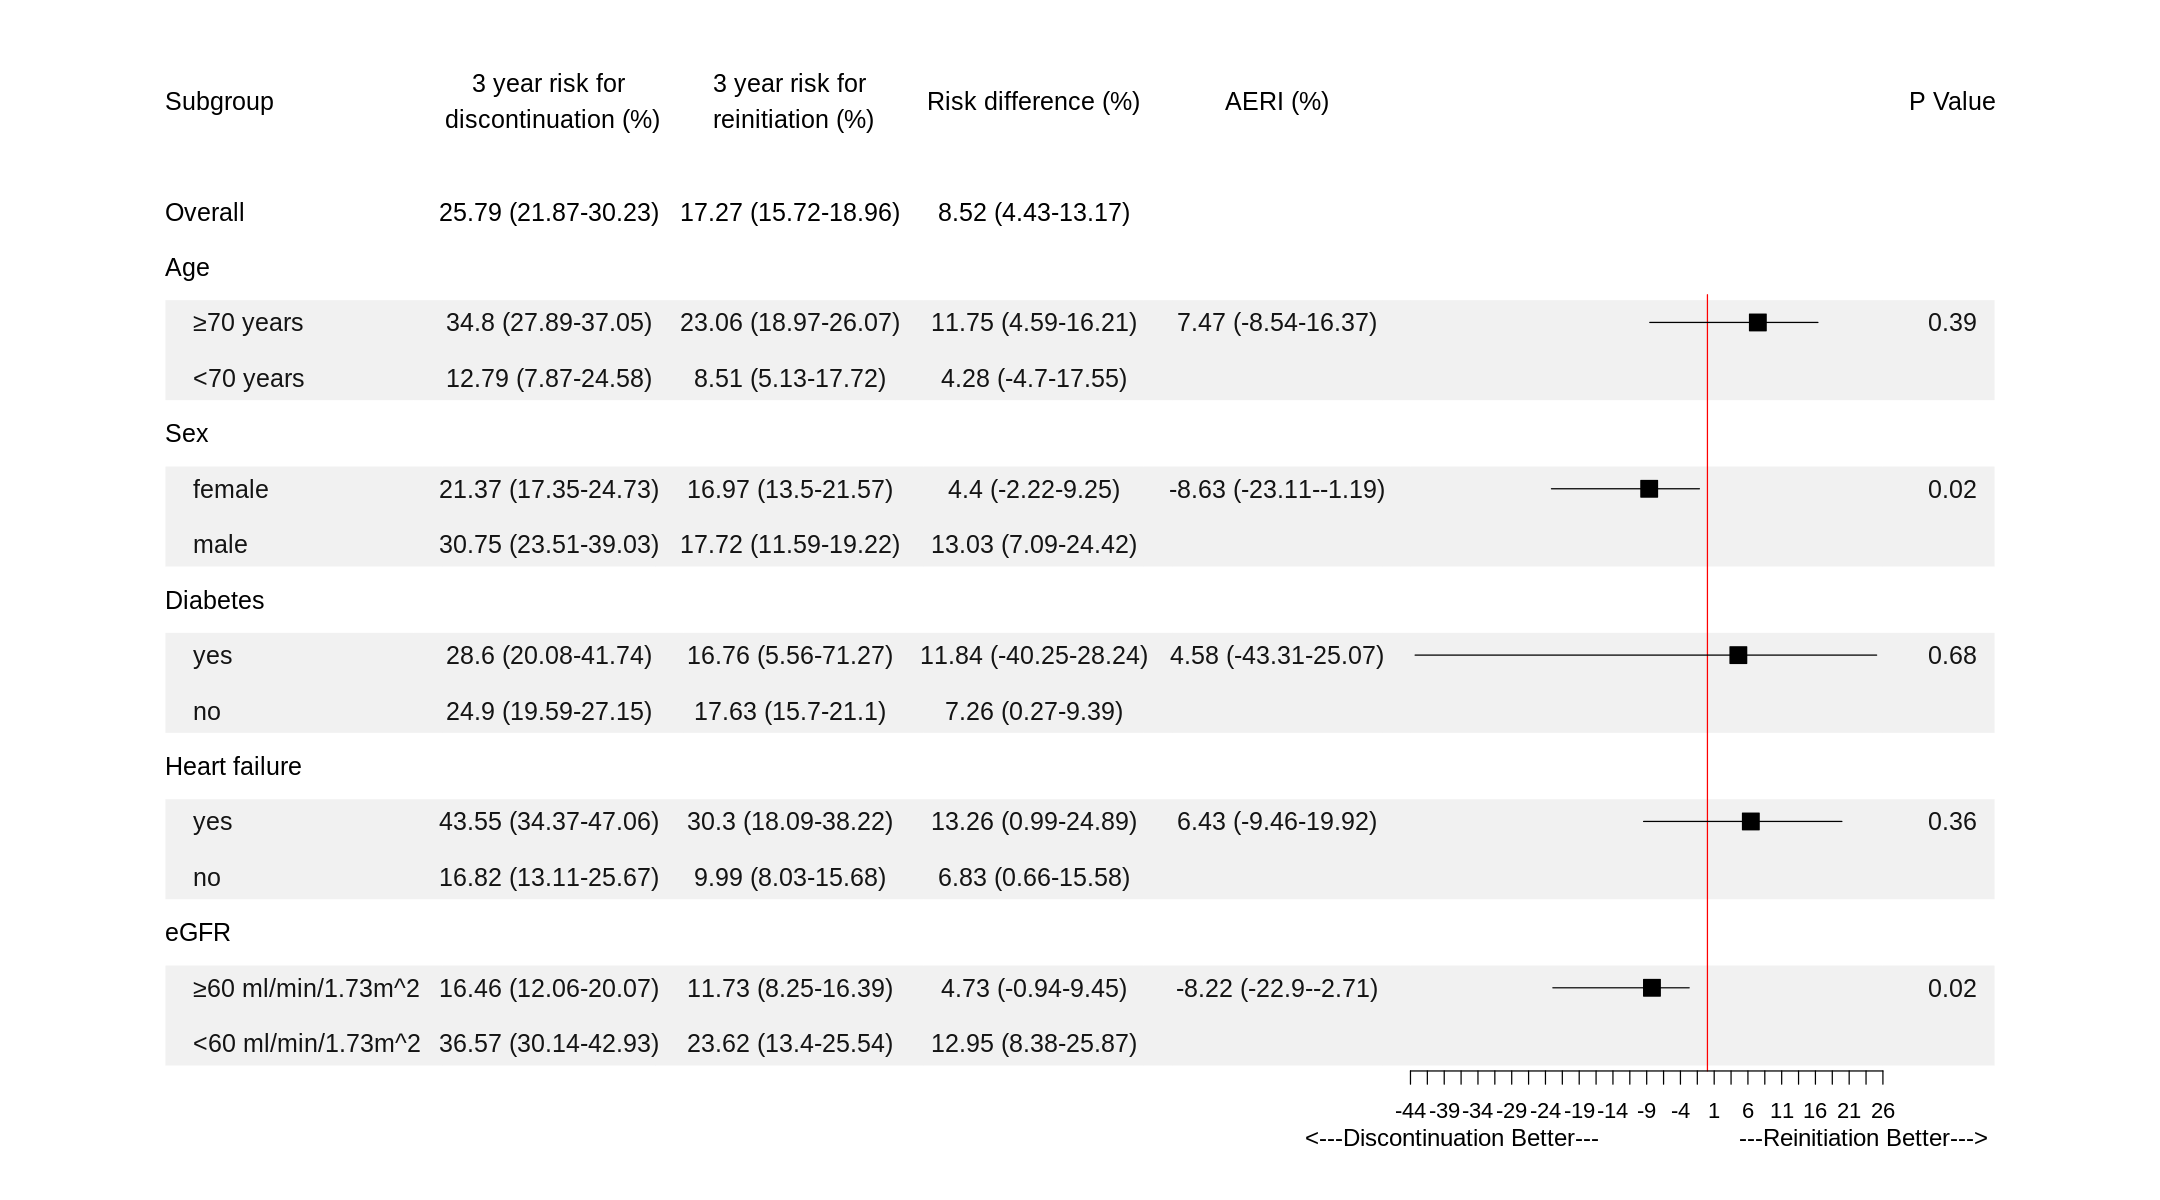

In [70]:
options(repr.plot.width = 18, repr.plot.height = 10)
forestplot(labeltext = tabletext, 
           graph.pos = 6, 
           mean = c(NA, NA, as.numeric(as.character(sub_res[['AERI point']]))), 
           lower = c(NA, NA, as.numeric(as.character(sub_res[['AERI lci']]))), 
           upper = c(NA, NA, as.numeric(as.character(sub_res[['AERI uci']]))), 
           title = "", 
           xlab = "<---Discontinuation Better---                    ---Reinitiation Better--->",
           hrzl_lines = list("6" = gpar(lwd = 80, lineend = "butt", columns=c(1 : 7), col="#99999922"), 
                             "9" = gpar(lwd = 80, lineend = "butt", columns=c(1 : 7), col="#99999922"),
                             "12" = gpar(lwd = 80, lineend = "butt", columns=c(1 : 7), col="#99999922"), 
                             "15" = gpar(lwd = 80, lineend = "butt", columns=c(1 : 7), col="#99999922"),
                             "18" = gpar(lwd = 80, lineend = "butt", columns=c(1 : 7), col="#99999922")), 
           txt_gp = fpTxtGp(label = gpar(cex = 1.25),
                            ticks = gpar(cex = 1.1),
                            xlab = gpar(cex = 1.2),
                            title = gpar(cex = 1.2)),
           col = fpColors(box = "black", lines = "black", zero = "red"),
           graphwidth = unit(100, 'mm'), 
           colgap = unit(6, "mm"),
           boxsize = 0.3)